# **United Soccer League Web Scraper** 

### Before viewing, I advise you to view it [here](https://nbviewer.jupyter.org/github/justingill/Resume-Portfolio/blob/master/USL%20Scraper/USL_Scraper.ipynb) instead because Github doesn't support Plotly charts.

In this project, we will be interested in examining the performance of my local Reno soccer team, [Reno 1868 FC](https://www.reno1868fc.com/). We must first start this project by obtaining the data needed to produce interpretable results. Luckily, the [USL website](https://www.uslsoccer.com/usl-statistics) keeps a very good record of league, team, and player stats which we may scrape for our own analytical use. 

![](https://www.visitrenotahoe.com/wp-content/uploads/2017/06/Reno1868Blog-1.jpg)

## **Import Libraries**

Let's start by importing all the libraries we will use for this project.

In [1]:
import seaborn as sns
import functools
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import sqlite3
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException, NoSuchElementException
import time
import datetime
import plotly.offline
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.dashboard_objs as dashboard

plotly.offline.init_notebook_mode(connected=True)

%matplotlib inline

## **Define Functions**

We start this project by first defining the necessary functions for scraping and creating our dataframe we wish to work with.

* ***get_latest_opponent*** - This function visits ESPN's [website](http://www.espn.com/soccer/team/fixtures/_/id/18453/reno-1868-fc) for Reno 1868 and scrapes the displayed matches for Reno 1868's next opponent; returning a dataframe with only players from Reno 1868 and their opponent.

* ***check_first_last*** - This will check the player list and make sure that the player has both a first and last name.

* ***make_team_df*** - This function will create a dataframe for the team using the html scraped by BeautifulSoup and return a dataframe to be merged into a dataframe of all the teams.

* ***save_to_SQL*** - This function will clean up the dataframe by creating a new column 'Player',dropping unnecessary columns, replacing placeholder values, correcting data types for columns, setting Player as the index, then saving it to a SQL database.
                  
* ***scrape_USL*** - This function acts as a 'main' function and encompasses the scraping of the data, cleaning and writing to SQL database. This function scrapes USL's [Standings](https://www.uslsoccer.com/usl-standings) to obtain all current teams playing in the USL. The soup objects of each team webpage are then passed into make_team_df and merged together. Lastly, this dataframe is cleaned by save_to_sql and saved to a SQL database.


In [2]:
def get_latest_opponent(usl):
    release = False
    while(release == False):
        options = webdriver.ChromeOptions()
        options.add_argument('headless')
        driver = webdriver.Chrome(executable_path="/Users/Justin/Desktop/chromedriver",options=options)
        driver.get('https://www.reno1868fc.com/2018-schedule')
        soup2 = BeautifulSoup(driver.page_source,'html.parser')
        driver.quit()
        try:
            opponent = soup2.find(class_='tableWrapper'
                             ).find('tbody'
                                   ).find_all('tr'
                                             )[-4].get_text(' '
                                                           ).split('\n'
                                                                  )[3].strip().replace(' ','-')
            release = True
        except:
            print('Latest Opponent Page Error.. Retrying')
            
    
    renovs = usl[(usl['Team'] == 'Reno-1868-FC') 
                 | (usl['Team'] == str(opponent))]
    return renovs

check_first_last simply makes sure our dataframe stays the same size by adding a blank first or last name if either is missing.

In [3]:
def check_first_last(player_list,length):
    if player_list == None:
        return player_list
    if len(player_list) == (length+1):
        player_list[1] = ' '.join(player_list[1:3])
        del player_list[2]
        return player_list
    elif len(player_list) == (length-1):
        player_list.insert(1,'-')
        return player_list
    else:
        return player_list

make_team_df takes in a soup variable which corresponds to a team page, which looks like [this](https://www.uslsoccer.com/reno-1868-fc-player-stats). We scrape the page for the data contained in the 'Full Player Stats' section, merge and return the manipulated dataframe. 

In [4]:
def make_team_df(soup):
    seperations = len(soup.find(class_='Opta-Table-Scroll Opta-Table-Scroll-One-Liner Opta-js-discipline'
                               ).find_all(role='row'))-1
    
    length_rows = len(soup.find_all(role='row'))

    general_columns = ['First','Last','Games Played','Starts','Subbed off','Minutes Played']
    
    distribution_columns = ['First','Last','Passes','Passing Acc','Long Passes','Long Pass Acc',
                            'Pass per 90','Forward Passes','Backward Passes','Left Pass',
                            'Right Pass','Passing Acc Opponents Half',
                            'Passing Acc Own Half','Assists','Key Passes','Crosses','Crossing Acc']
    
    attack_columns = ['First','Last','Shots','Shots on Target','Goals','Right Foot Goals',
                      'Left Foot Goals','Heading Goals','Other','Goals In Box','Goals Out Box',
                      'Free Kick Goals','Conversion Rate','Mins Per Goal']
    
    defense_columns = ['First','Last','Clears','Blocks','Interceptions','Tackles',
                       'Tackles Won','Duels','Duels Won','Air Duels','Air Duels Won']
    discipline_columns = ['First','Last','Yellow Cards','Red Cards','Fouls Won','Fouls Conceded']

    goalkeeping_columns = ['First','Last','Goals Conceded','Shot At','Saves','Save Rate',
                           'Clean Sheets','Catches','Punches','Drops','Penalties Saved',
                           'Clearances']
    
    discipline_df = pd.DataFrame([check_first_last(player.get_text(' ').split(' '),
                                                   len(discipline_columns)) 
                                  for player in soup.find_all(role='row')[seperations*4+5:seperations*5+5]],
                                 columns=discipline_columns)
    
    defense_df = pd.DataFrame([check_first_last(player.get_text(' ').split(' '),
                                                len(defense_columns)) 
                               for player in soup.find_all(role='row')[seperations*3+4:seperations*4+4]],
                              columns=defense_columns)
    
    attack_df = pd.DataFrame([check_first_last(player.get_text(' ').split(' '),
                                               len(attack_columns)) 
                              for player in soup.find_all(role='row')[seperations*2+3:seperations*3+3]],
                             columns=attack_columns)
    
    distribution_df = pd.DataFrame([check_first_last(player.get_text(' ').split(' '),
                                                     len(distribution_columns)) 
                                    for player in soup.find_all(role='row')[seperations+2:seperations*2+2]],
                                   columns=distribution_columns)
    
    general_df = pd.DataFrame([check_first_last(player.get_text(' ').split(' '),
                                                len(general_columns)) 
                               for player in soup.find_all(role='row')[1:seperations+1]],
                             columns=general_columns)
    
    goalkeeping_df = pd.DataFrame([check_first_last(player.get_text(' ').split(' '),
                                len(goalkeeping_columns))for player in soup.find_all(role='row')[seperations*5+6:length_rows]],
                                 columns=goalkeeping_columns)

    df = [general_df,distribution_df,attack_df,defense_df,discipline_df,goalkeeping_df]
    df_merge = functools.reduce(lambda left,right: pd.merge(left,right,on=['First','Last'],
                                                how='outer'), df).fillna(0)
    return df_merge

save_to_SQL cleans the passed dataframe and saves it as a new table named after the current date, then returns the cleaned dataframe.

In [5]:
def save_to_SQL(usl):
    usl.replace('-',0,inplace=True)
    usl = usl.applymap(lambda x: str(x).replace(',',''))
    usl['Player'] = usl['First']+ ' ' + usl['Last']
    usl.set_index('Player',drop=True,inplace=True)
    usl.drop(['First','Last'],axis=1,inplace=True)

    float_types = [e for e in list(usl.columns) if e not in ['Player','Team']]
    usl[float_types] = usl[float_types].applymap(lambda x: round(float(x),3))
    usl['Subbed on'] = usl['Games Played'] - usl['Starts']
    con = sqlite3.connect('USL.sqlite')
    usl.to_sql((str(datetime.date.today())),con,if_exists='replace')
    return usl

scrape_USL acts almost as a 'main' function for the program. It starts up a chrome webdriver using Selenium and proceeds to access the [league standings](https://www.uslsoccer.com/usl-standings). We scrape this page for all the current teams and then store this data away in a list. We can then use this list to visit all the team stats webpages and collect individual data for each player.

In [6]:
def scrape_USL():
    start = time.time()
    standing_release = False
    while(standing_release == False):
        options = webdriver.ChromeOptions()
        driver = webdriver.Chrome(executable_path="/home/justin/Downloads/chromedriver",options=options)
        driver.get('https://www.uslsoccer.com/usl-standings')
        time.sleep(1)
        presoup = BeautifulSoup(driver.page_source,'html.parser')
        try:
            teams = [team.get_text().replace(' ','-').lower() 
                     if team.get_text() != 'Pittsburgh Riverhounds SC' 
                     else 'Pittsburgh-Riverhounds'.lower() 
                     for team in presoup.find_all(class_='Opta-TeamLink Opta-Ext')]
            standing_release = True
        except:
            print('Error Loading Standings. Retrying...')

    url = 'https://www.uslchampionship.com/{}-player-stats'

    usl = pd.DataFrame()
    
    for team in teams:
        release = False
        while(release == False):
            driver.get(url.format(team))
            timeout = 10
            try:
                element_present = EC.visibility_of_element_located((By.CLASS_NAME,
                                                                    'Opta-TabbedContent'))
                WebDriverWait(driver, timeout).until(element_present)
            except TimeoutException:
                print("Timed out waiting for {}".format(team))

            try:
                soup = BeautifulSoup(driver.page_source,'html5lib')
                team_df = make_team_df(soup)
                team_df['Team'] = team
                usl = pd.concat([usl,team_df],axis=0)
                release = True
            except:
                release=False

    usl = save_to_SQL(usl)
    driver.quit()
    stop = time.time()
    return usl,stop-start

Let's call our function!

In [7]:
usl,runtime = scrape_USL()
print("Program ran in : {} seconds.".format(runtime))

Program ran in : 231.0396499633789 seconds.


/home/justin/anaconda3/envs/Github_Projects/lib/python3.6/site-packages/pandas/core/generic.py:2130: UserWarning:

The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.



Let's check the league dataframe.

In [8]:
usl.head()

,Games Played,Starts,Subbed off,Minutes Played,Passes,Passing Acc,Long Passes,Long Pass Acc,Pass per 90,Forward Passes,...,Saves,Save Rate,Clean Sheets,Catches,Punches,Drops,Penalties Saved,Clearances,Team,Subbed on
Player,,,,,,,,,,,,,,,,,,,,,
Blake Smith,32.0,30.0,4.0,2698.0,1388.0,79.7,193.0,48.7,46.3,601.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fc-cincinnati,2.0
Corben Bone,34.0,32.0,10.0,2810.0,1491.0,83.6,96.0,65.6,47.8,364.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fc-cincinnati,2.0
Daniel Haber,17.0,5.0,5.0,490.0,158.0,72.2,12.0,16.7,29.0,46.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fc-cincinnati,12.0
Danni Konig,28.0,17.0,14.0,1558.0,331.0,63.7,5.0,20.0,19.1,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fc-cincinnati,11.0
Dekel Keinan,22.0,22.0,1.0,1926.0,863.0,80.6,154.0,44.2,40.3,380.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fc-cincinnati,0.0


Great! We can also check that our SQL database is working correctly.

In [9]:
con = sqlite3.connect('USL.sqlite')
usl_read = pd.read_sql_query('Select * from "{}"'.format(str(datetime.date.today())),
                             con,
                             coerce_float=True)
con.close()

In [10]:
usl_read.head(5)

,Player,Games Played,Starts,Subbed off,Minutes Played,Passes,Passing Acc,Long Passes,Long Pass Acc,Pass per 90,...,Saves,Save Rate,Clean Sheets,Catches,Punches,Drops,Penalties Saved,Clearances,Team,Subbed on
0,Blake Smith,32.0,30.0,4.0,2698.0,1388.0,79.7,193.0,48.7,46.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fc-cincinnati,2.0
1,Corben Bone,34.0,32.0,10.0,2810.0,1491.0,83.6,96.0,65.6,47.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fc-cincinnati,2.0
2,Daniel Haber,17.0,5.0,5.0,490.0,158.0,72.2,12.0,16.7,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fc-cincinnati,12.0
3,Danni Konig,28.0,17.0,14.0,1558.0,331.0,63.7,5.0,20.0,19.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fc-cincinnati,11.0
4,Dekel Keinan,22.0,22.0,1.0,1926.0,863.0,80.6,154.0,44.2,40.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fc-cincinnati,0.0


As we can see, our dataframe reads in correctly.

## **Reno 1868 EDA**

We are interested in comparing Reno 1868 to their next opponent to help us understand statistically how they stack up against one another.

Let's view some quick statistics about our dataset first.

In [11]:
usl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, Blake Smith to Wyatt Omsberg
Data columns (total 56 columns):
Games Played                  1016 non-null float64
Starts                        1016 non-null float64
Subbed off                    1016 non-null float64
Minutes Played                1016 non-null float64
Passes                        1016 non-null float64
Passing Acc                   1016 non-null float64
Long Passes                   1016 non-null float64
Long Pass Acc                 1016 non-null float64
Pass per 90                   1016 non-null float64
Forward Passes                1016 non-null float64
Backward Passes               1016 non-null float64
Left Pass                     1016 non-null float64
Right Pass                    1016 non-null float64
Passing Acc Opponents Half    1016 non-null float64
Passing Acc Own Half          1016 non-null float64
Assists                       1016 non-null float64
Key Passes                    1016 non-null flo

In [12]:
usl.describe()

,Games Played,Starts,Subbed off,Minutes Played,Passes,Passing Acc,Long Passes,Long Pass Acc,Pass per 90,Forward Passes,...,Shot At,Saves,Save Rate,Clean Sheets,Catches,Punches,Drops,Penalties Saved,Clearances,Subbed on
count,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,...,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000
mean,16.041339,12.686024,3.330709,1141.045276,475.834646,74.673327,81.543307,47.034055,37.121161,181.059055,...,4.681102,3.125984,6.066043,0.278543,0.496063,0.385827,0.064961,0.034449,1.033465,3.355315
std,10.567832,9.822205,3.740457,871.456957,428.394473,11.372444,107.721316,20.110573,15.873886,181.114123,...,19.143757,12.912356,19.515747,1.386839,2.420354,1.828821,0.401613,0.238621,4.659950,3.873204
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,4.000000,0.000000,360.000000,129.000000,70.075000,11.000000,36.800000,27.750000,42.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15.000000,11.000000,2.000000,983.000000,363.000000,76.900000,41.000000,47.900000,35.350000,124.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,25.000000,21.000000,5.000000,1810.750000,714.250000,81.500000,109.250000,58.550000,44.425000,264.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
max,37.000000,37.000000,19.000000,3330.000000,2431.000000,100.000000,846.000000,100.000000,270.000000,911.000000,...,189.000000,125.000000,100.000000,15.000000,41.000000,20.000000,6.000000,4.000000,52.000000,26.000000


We must now get our subset using our function get_latest_opponent. 

In [ ]:
renovs = get_latest_opponent(usl)

Let's make sure this worked properly!

In [ ]:
renovs['Team'].value_counts()

Great! We now have our two teams.

We can now look at some of the more important statistics(displayed below) in soccer and see the differences between the two teams.

In [ ]:
compare = pd.concat(
    [
    renovs[['Goals',
             'Assists',
             'Crosses',
             'Key Passes',
             'Interceptions',
             'Clearances',
             'Team',
             'Shots on Target',
             'Shots',
             'Tackles']].groupby('Team').sum().transpose(),
                     
    renovs[['Conversion Rate',
            'Team',
            'Passing Acc']].groupby('Team').mean().transpose()
    ],
    
    axis=0
)
compare.applymap(lambda x: round(x,2))

## **Visualizations using Plotly**

We now want to visualize our data to help us get a better understanding of the individual team differences. We can use the plotly library to help us plot these.  

In [ ]:
opponent = (compare.columns).drop('Reno-1868-FC')

Let's first plot out our previous table and look at it.

In [ ]:
data  = [
        go.Bar(
    y = compare.index,
    x = compare['Reno-1868-FC'],
    orientation='h',
    marker=dict(color='#0c13a8'),
    name='Reno 1868 FC'),
    
         go.Bar(
    y = compare.index,
    x = compare[opponent[0]],
    orientation='h',
    marker=dict(color='#FF0033'),
    name=opponent[0].replace('-',' '))
]

layout = go.Layout(
        title = 'Reno 1868 vs. '+ opponent[0].replace('-',' '),
        margin = go.layout.Margin(l=110)
)

fig  = go.Figure(data=data,layout=layout)
# url_1 = py.plot(fig,auto_open=False)
# py.iplot(fig)
plotly.offline.iplot(fig)

Next, let's now look at the individual scorers and assisters on Reno 1868.

In [ ]:
data  = [
        go.Bar(
    y = renovs[(renovs['Team'] == 'Reno-1868-FC') 
               & (renovs['Goals'] > 0)]['Goals'].sort_values(ascending=True).index,
            
    x = renovs[(renovs['Team'] == 'Reno-1868-FC') 
               & (renovs['Goals'] > 0)]['Goals'].sort_values(ascending=True),
    orientation='h',
    marker=dict(color='#0c13a8'),
    name='Goals'),
    
        go.Bar(
    y = renovs[(renovs['Team'] == 'Reno-1868-FC') 
               & (renovs['Assists'] > 0)]['Assists'].sort_values(ascending=True).index,
            
    x = renovs[(renovs['Team'] == 'Reno-1868-FC') 
               & (renovs['Assists'] > 0)]['Assists'].sort_values(ascending=True),
    orientation='h',
    marker=dict(color='#fe6604'),
    name='Assists')
]

layout = go.Layout(
        title = 'Reno 1868 Scorers & Assisters',
        xaxis = dict(title='Total Goals & Assists'),
        barmode='stack',
        margin = go.layout.Margin(l=140),
        autosize=True

)

fig  = go.Figure(data=data, layout=layout)
# url_2 = py.plot(fig,auto_open=False)
# py.iplot(fig)
plotly.offline.iplot(fig)

Let's do the same for the opponent's team.

In [ ]:
data  = [
        go.Bar(
    y = renovs[(renovs['Team'] == opponent[0]) 
               & (renovs['Goals'] > 0)]['Goals'].sort_values(ascending=True).index,
            
    x = renovs[(renovs['Team'] == opponent[0]) 
               & (renovs['Goals'] > 0)]['Goals'].sort_values(ascending=True),
            
    orientation='h',
    marker=dict(color='#FF0033'),
    name='Goals'),
    
        go.Bar(
    y = renovs[(renovs['Team'] == opponent[0]) 
               & (renovs['Assists'] > 0)]['Assists'].sort_values(ascending=True).index,
            
    x = renovs[(renovs['Team'] == opponent[0]) 
               & (renovs['Assists'] > 0)]['Assists'].sort_values(ascending=True),
    orientation='h',
    marker=dict(color='#9A03FE'),
    name='Assists')
]

layout = go.Layout(
        title = opponent[0].replace('-',' ') + ' Scorers & Assisters',
        xaxis = dict(title='Total Goals & Assists'),
        barmode='stack',
        margin = go.layout.Margin(l=140),
        autosize=True
)

fig  = go.Figure(data=data, layout=layout)
# url_3 = py.plot(fig,auto_open=False)
# py.iplot(fig)
plotly.offline.iplot(fig)

## **Plotly Dashboard**

We can also make this into an updated dashboard every time we run our notebook. Unfortunately, I was not able to get this working, particularly due to incompatible versions of libraries. Though it does not work currently, this code would produce a dashboard on my personal Plotly account. I will leave this here just to show my thought process on other things I can do with this project!

In [ ]:
# my_dboard = dashboard.Dashboard()

In [ ]:
# my_dboard.get_preview()

In [ ]:
'''
import re

def fileId_from_url(url):
    raw_fileId = re.findall("~[A-z]+/[0-9]+", url)[0][1:]
    return str(raw_fileId).replace('/', ':')

def sharekey_from_url(url):
    if 'share_key=' not in url:
        return "This url is not 'sercret'. It does not have a secret key."
    return url[url.find('share_key=') + len('share_key='):]

fileId_1 = fileId_from_url(url_1)
fileId_2 = fileId_from_url(url_2)
fileId_3 = fileId_from_url(url_3)
print(fileId_1)
print(fileId_2)
print(fileId_3)

box_a = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': fileId_1,
    'title': 'Reno 1868 vs. ' + str(opponent).replace('-',' ')
}
box_b = {
    'type': 'box',
    'boxType': 'plot',
    'fileID': fileId_2,
    'title':  'Reno 1868 Top Scorers & Assisters'
}
box_c = {
    'type': 'box',
    'boxType': 'plot',
    'fileID': fileId_3,
    'title':  str(opponent).replace('-',' ') + ' Top Scorers & Assisters'
}
'''

In [ ]:
# my_dboard['settings']['title'] = 'Reno 1868'

In [ ]:
# my_dboard['settings']['logoUrl'] = 'https://media.graytvinc.com/images/810*954/1868-SOCCER-KIT.jpg'

In [ ]:
# my_dboard.insert(box_a)

In [ ]:
# my_dboard.insert(box_b,'above',1)

In [ ]:
# my_dboard.insert(box_c,'right',1)

In [ ]:
# py.dashboard_ops.upload(my_dboard, 'Reno 1868 Dashboard',sharing='public',auto_open=True)

## **Positions using Decision Tree**

In [59]:
reno_positions = {'Position':{'Antoine Hoppenot':'Midfielder','Brent Richards':'Defender',
                         'Brenton Griffiths':'Defender','Brian Brown':'Forward',
                         'Christian Thierjung':'Midfielder','Christopher Wehan':'Midfielder',
                         'Daniel Musovski':'Forward','Darwin Espinal':'Midfielder',
                         'Duke Lacroix':'Midfielder','Eric Calvillo':'Midfielder',
                         'Gilbert Fuentes':'Midfielder','Jackson Yueill':'Midfielder',
                         'James Kiffe':'Defender','James Marcinkowski':'Goalkeeper',
                         'Jerry van Ewijk':'Midfielder','Jimmy Ockford':'Defender',
                         'Guy Abend':'Midfielder','Antoine Hoppenot':'Midfielder',
                         'Jochen Graf':'Forward','Joel Qwiberg':'Defender',
                         'Jordan Murrell':'Defender','Kevin Partida':'Midfielder',
                         'Kyle Ihn':'Defender','Lindo Mfeka':'Midfielder',
                         'Luis Felipe Fernandes':'Midfielder','Mark González':'Forward',
                         'Matt Bersano':'Goalkeeper','Mohamed Thiaw':'Forward',
                         'Paul Marie':'Defender','Seth Casiple':'Midfielder',
                         'Thomas Janjigian':'Defender','Will Seymore':'Midfielder',
                         'Zach Carroll':'Defender'}}
usl['Position'] = pd.DataFrame(reno_positions)

In [60]:
data = usl[usl['Games Played']>3]

In [61]:
usl.head()

,Games Played,Starts,Subbed off,Minutes Played,Passes,Passing Acc,Long Passes,Long Pass Acc,Pass per 90,Forward Passes,...,Save Rate,Clean Sheets,Catches,Punches,Drops,Penalties Saved,Clearances,Team,Subbed on,Position
Player,,,,,,,,,,,,,,,,,,,,,
Blake Smith,32.0,30.0,4.0,2698.0,1388.0,79.7,193.0,48.7,46.3,601.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fc-cincinnati,2.0,NaN
Corben Bone,34.0,32.0,10.0,2810.0,1491.0,83.6,96.0,65.6,47.8,364.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fc-cincinnati,2.0,NaN
Daniel Haber,17.0,5.0,5.0,490.0,158.0,72.2,12.0,16.7,29.0,46.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fc-cincinnati,12.0,NaN
Danni Konig,28.0,17.0,14.0,1558.0,331.0,63.7,5.0,20.0,19.1,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fc-cincinnati,11.0,NaN
Dekel Keinan,22.0,22.0,1.0,1926.0,863.0,80.6,154.0,44.2,40.3,380.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fc-cincinnati,0.0,NaN


In [62]:
reno = data[data['Team'] == 'reno-1868-fc'].copy()
rest = data[data['Team'] != 'reno-1868-fc'].copy()

In [63]:
len(reno)

28

In [64]:
len(rest)

842

In [65]:
reno

,Games Played,Starts,Subbed off,Minutes Played,Passes,Passing Acc,Long Passes,Long Pass Acc,Pass per 90,Forward Passes,...,Save Rate,Clean Sheets,Catches,Punches,Drops,Penalties Saved,Clearances,Team,Subbed on,Position
Player,,,,,,,,,,,,,,,,,,,,,
Antoine Hoppenot,34.0,30.0,9.0,2590.0,728.0,69.9,68.0,39.7,25.3,197.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,reno-1868-fc,4.0,Midfielder
Brent Richards,33.0,29.0,1.0,2696.0,1243.0,72.9,170.0,51.8,41.5,609.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,reno-1868-fc,4.0,Defender
Brenton Griffiths,15.0,13.0,0.0,1205.0,540.0,85.0,93.0,63.4,40.3,237.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,reno-1868-fc,2.0,Defender
Brian Brown,34.0,22.0,14.0,2192.0,639.0,77.0,16.0,75.0,26.2,129.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,reno-1868-fc,12.0,Forward
Christian Thierjung,5.0,2.0,0.0,238.0,45.0,73.3,5.0,40.0,17.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,reno-1868-fc,3.0,Midfielder
Christopher Wehan,14.0,14.0,8.0,1077.0,438.0,77.4,40.0,47.5,36.6,110.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,reno-1868-fc,0.0,Midfielder
Daniel Musovski,17.0,10.0,7.0,794.0,229.0,66.4,9.0,55.6,26.0,44.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,reno-1868-fc,7.0,Forward
Duke Lacroix,28.0,23.0,0.0,2145.0,822.0,81.3,71.0,53.5,34.5,316.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,reno-1868-fc,5.0,Midfielder
Eric Calvillo,11.0,10.0,2.0,800.0,462.0,85.1,56.0,62.5,52.0,150.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,reno-1868-fc,1.0,Midfielder


In [67]:
rest.head()

,Games Played,Starts,Subbed off,Minutes Played,Passes,Passing Acc,Long Passes,Long Pass Acc,Pass per 90,Forward Passes,...,Save Rate,Clean Sheets,Catches,Punches,Drops,Penalties Saved,Clearances,Team,Subbed on,Position
Player,,,,,,,,,,,,,,,,,,,,,
Blake Smith,32.0,30.0,4.0,2698.0,1388.0,79.7,193.0,48.7,46.3,601.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fc-cincinnati,2.0,NaN
Corben Bone,34.0,32.0,10.0,2810.0,1491.0,83.6,96.0,65.6,47.8,364.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fc-cincinnati,2.0,NaN
Daniel Haber,17.0,5.0,5.0,490.0,158.0,72.2,12.0,16.7,29.0,46.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fc-cincinnati,12.0,NaN
Danni Konig,28.0,17.0,14.0,1558.0,331.0,63.7,5.0,20.0,19.1,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fc-cincinnati,11.0,NaN
Dekel Keinan,22.0,22.0,1.0,1926.0,863.0,80.6,154.0,44.2,40.3,380.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fc-cincinnati,0.0,NaN


In [82]:
train = data[data['Position'].notna()]
test = data[data['Position'].isna()].drop(['Team','Position'],axis=1)

In [83]:
X = train.drop(['Position','Team'],axis=1)
y = train['Position']

In [148]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn import tree

clf = DecisionTreeClassifier()
clf_fit = clf.fit(X,y)

In [149]:
export_graphviz(clf, out_file='tree.dot', feature_names = X.columns,
                class_names = ['Defender','Forward','Goalkeeper','Midfielder'],
                rounded = True, proportion = False, precision = 2, filled = True)

To turn dot file into png, you must use the command line command 'dot -Tpng tree.dot -o tree.png -Gdpi=600'

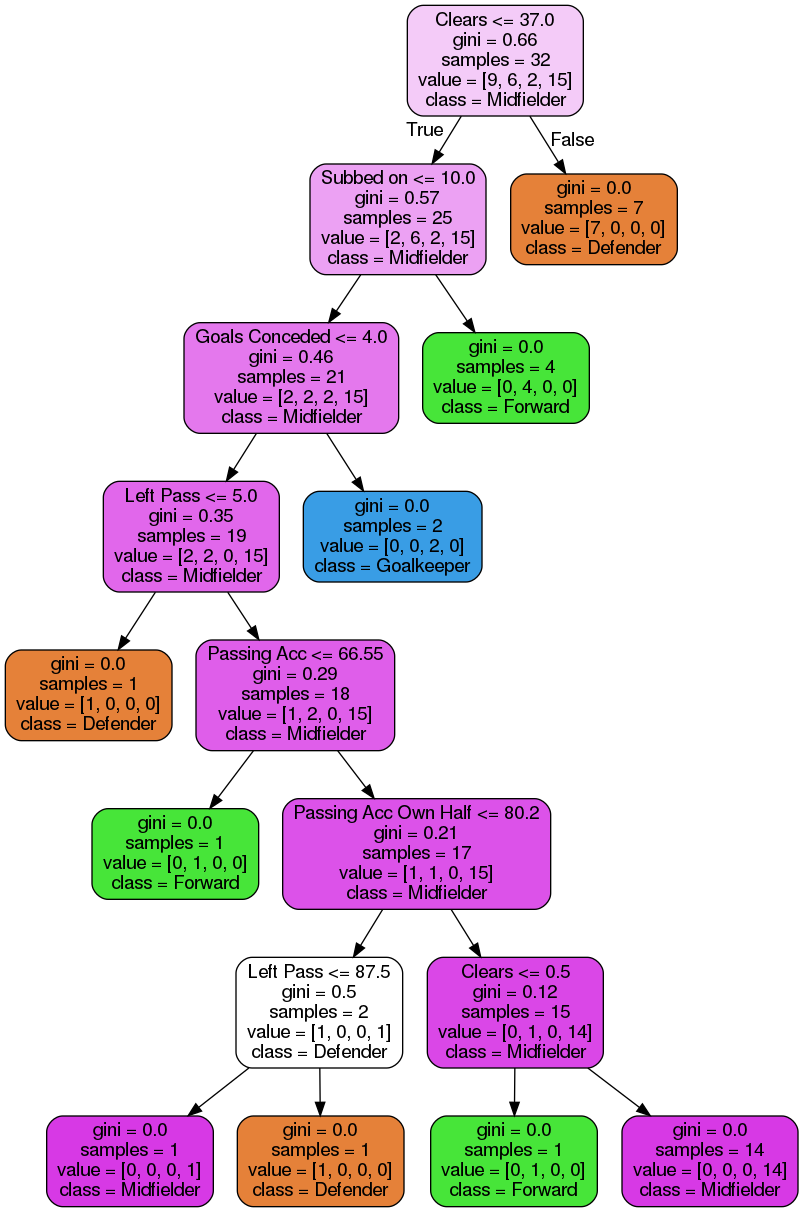

In [150]:
from IPython.display import Image
Image(filename = 'tree.png')

In [132]:
clf_fit

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [87]:
predict = clf.predict(test)

In [89]:
predict[:10]

array(['Defender', 'Midfielder', 'Forward', 'Forward', 'Defender',
       'Forward', 'Midfielder', 'Goalkeeper', 'Midfielder', 'Midfielder'],
      dtype=object)

In [90]:
test[:10]

,Games Played,Starts,Subbed off,Minutes Played,Passes,Passing Acc,Long Passes,Long Pass Acc,Pass per 90,Forward Passes,...,Shot At,Saves,Save Rate,Clean Sheets,Catches,Punches,Drops,Penalties Saved,Clearances,Subbed on
Player,,,,,,,,,,,,,,,,,,,,,
Blake Smith,32.0,30.0,4.0,2698.0,1388.0,79.7,193.0,48.7,46.3,601.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
Corben Bone,34.0,32.0,10.0,2810.0,1491.0,83.6,96.0,65.6,47.8,364.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
Daniel Haber,17.0,5.0,5.0,490.0,158.0,72.2,12.0,16.7,29.0,46.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
Danni Konig,28.0,17.0,14.0,1558.0,331.0,63.7,5.0,20.0,19.1,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
Dekel Keinan,22.0,22.0,1.0,1926.0,863.0,80.6,154.0,44.2,40.3,380.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Emery Welshman,28.0,14.0,12.0,1285.0,381.0,69.8,13.0,61.5,26.7,87.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0
Emmanuel Ledesma,33.0,32.0,13.0,2795.0,1090.0,69.4,182.0,53.8,35.1,304.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Evan Newton,20.0,20.0,0.0,1800.0,513.0,51.7,393.0,37.2,25.6,410.0,...,72.0,56.0,77.8,9.0,6.0,14.0,0.0,1.0,25.0,0.0
Fanendo Adi,11.0,6.0,4.0,592.0,186.0,72.0,8.0,37.5,28.3,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
